In [1]:
import torch

import os

import numpy as np
import statistics

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import models

In [2]:
from preprocess import preprocess

The next technique tested was transfer learning. A pre-trained EfficientNet model was used, with only a slight modification in the final linear layer, that was adjusted to the correct output size and trained. Except of that the entire EfficientNet as the backbone architecture.

### Preprocessing

In [3]:
dataset = torch.load("dataset.pth")

In [4]:
weights = torch.load("weights.pth")

Dataset was adjusted as the EfficientNet requires 3 input channels and not 1 chanel grayscale

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

In [6]:
trainloader,testloader,valloader = preprocess(dataset, 64, transform)

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

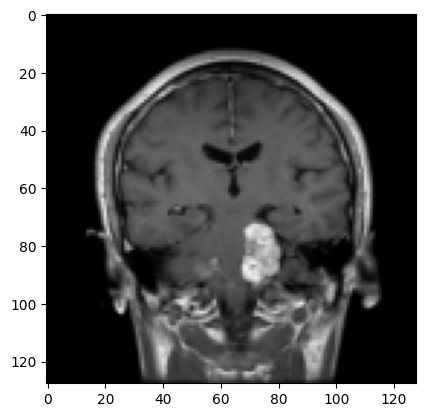

tensor(2)


In [8]:
sample_id = 5

img = images[sample_id].permute(1, 2, 0).numpy()
plt.imshow(img)

plt.show()

print(labels[sample_id])

### Model

The pre-trained model was loaded, and all pre-trained layers were frozen except for the final linear layer, which was adjusted to match the final output size.

In [9]:
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

In [10]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
model.classifier[1] = nn.Linear(in_features=1280, out_features=4)

In [12]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [14]:
device = torch.device(os.getenv("DEVICE"))
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [16]:
train_loss_plot = []
test_loss_plot = []

In [17]:
best_result = np.inf
test_loss_array = []
n_epochs = 15
patience = 3

for epoch in range(n_epochs):

    total_loss = 0
    for X_batch, y_batch in trainloader:

        X_batch = X_batch.to(device,dtype=torch.float32)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)

        loss = criterion(outputs.to(device), y_batch)
        train_loss_plot.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

    test_loss = 0
    with torch.no_grad():  
            
            for X_batch, y_batch in testloader:

                X_batch = X_batch.to(device,dtype=torch.float32)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                t_loss = criterion(outputs.to(device), y_batch)
                test_loss_plot.append(t_loss.item())

                test_loss+=t_loss

    loss = total_loss / (len(trainloader))
    loss_test = test_loss / (len(testloader))

    test_loss_array.append(loss_test)

    if loss_test < best_result:
        torch.save(model.state_dict(), "./efficient_net.pth")

    print(f"Epoch: {epoch}, Train loss: {loss}, Test loss: {loss_test}")

    if len(test_loss_array)>patience+1:
        if not (any(x > (test_loss_array[-1]+0.001) for x in test_loss_array[len(test_loss_array)-patience-1:-1])):
            break

Epoch: 0, Train loss: 1.0183336706832051, Test loss: 0.8438742160797119
Epoch: 1, Train loss: 0.7141346056014299, Test loss: 0.6879108548164368
Epoch: 2, Train loss: 0.6242811121046543, Test loss: 0.6371219754219055
Epoch: 3, Train loss: 0.5758694624528289, Test loss: 0.6164923310279846
Epoch: 4, Train loss: 0.5259189167991281, Test loss: 0.5525063276290894
Epoch: 5, Train loss: 0.5033510774374008, Test loss: 0.5751157402992249
Epoch: 6, Train loss: 0.46746709872968495, Test loss: 0.5157703757286072
Epoch: 7, Train loss: 0.46519158501178026, Test loss: 0.512721598148346
Epoch: 8, Train loss: 0.46735889557749033, Test loss: 0.5312766432762146
Epoch: 9, Train loss: 0.4391366536729038, Test loss: 0.5176386833190918
Epoch: 10, Train loss: 0.43308741925284266, Test loss: 0.5030930042266846
Epoch: 11, Train loss: 0.427358235232532, Test loss: 0.47040221095085144
Epoch: 12, Train loss: 0.4336160649545491, Test loss: 0.5115724205970764
Epoch: 13, Train loss: 0.4087530765682459, Test loss: 0.49

The training process took longer compared to the simpler network, but the trend in los decrease is quite visible on both the training and testing datasets. In both datasets huge spikes in loss occur which suggest that the proces is not very stable, however after more samples (as batches are iterated) decreases again.

In [24]:
model.load_state_dict(torch.load("./efficient_net.pth"))

<All keys matched successfully>

### Results

<Axes: >

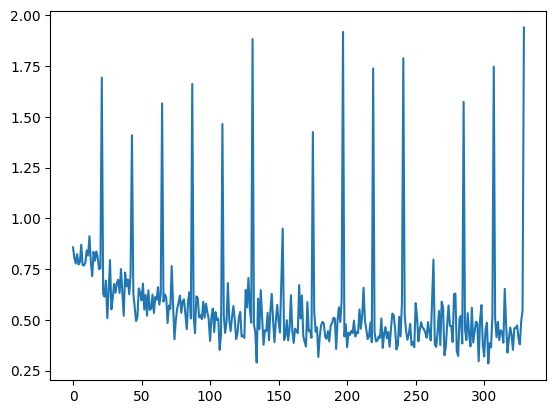

In [25]:
import seaborn as sns

sns.lineplot(data = test_loss_plot)

<Axes: >

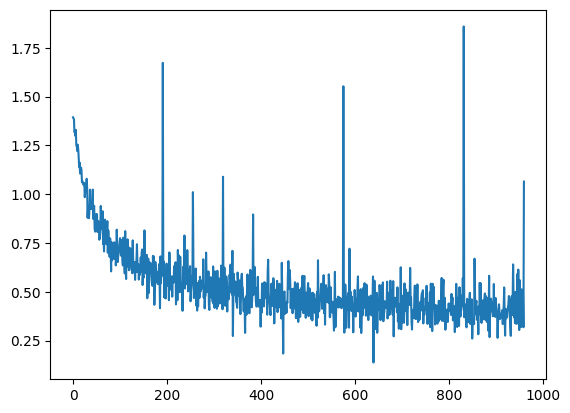

In [26]:
sns.lineplot(data = train_loss_plot)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [31]:
accuracy = []
f1_scr = []
precision = []
recall=[]

with torch.no_grad():
    
    for X_batch, y_batch in valloader:
        outputs_pred = model(X_batch.to(device))

        _, topi = outputs_pred.topk(1)

        topi=topi.cpu()

        acc = accuracy_score(y_batch,topi.squeeze(-1))
        f1 = f1_score(y_batch,topi.squeeze(-1), average="macro")
        pr = precision_score(y_batch,topi.squeeze(-1), average="macro")
        rec = recall_score(y_batch,topi.squeeze(-1),average="macro")


        accuracy.append(float(acc))
        f1_scr.append(float(f1))
        precision.append(float(pr))
        recall.append(float(rec))


Even though the training process seemed more stable, the final model accuracy was slightly lower compared to the custom model. The reason may be the fact that pre-trained weights were not suitable for this task, I believe it is caused by differences in the train dataset for EfficientNet that was originally trained on RGB images and may not be that suitable for grayscale images.

In [32]:
print(statistics.mean(accuracy))
print(statistics.mean(f1_scr))
print(statistics.mean(precision))
print(statistics.mean(recall))

0.8373579545454546
0.8353655803946184
0.8409802973558419
0.84685284637528
